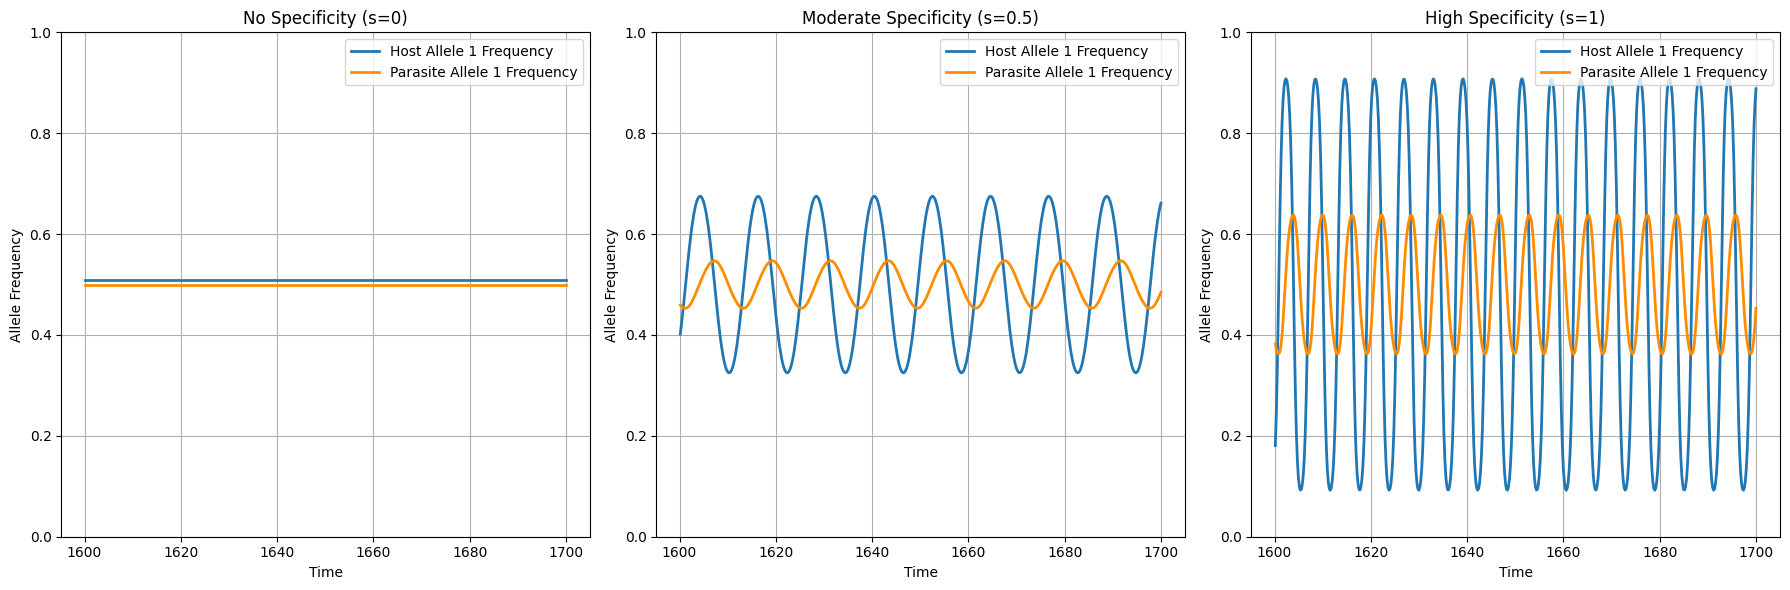

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

d = 1             # natural mortality (set to 1 by non-dimensionalization)
q = 1              # density-dependent competition coefficient (set to 1)
b = 10.0              # intrinsic birth rate
gamma = 1.0        # recovery rate
alpha = 1.5         # virulence trait (for our single-virulence-class simulation)
theta_tilde = 20.0 # scaling factor for parasite shedding rate
delta = 0.3         # parasite decay rate
beta0 = 1.5         # underlying infection rate constant
n = 2               # number of infection alleles (host and parasite)
beta = beta0 * n    # baseline infection rate: β(n)=β₀×n

# For a parasite with virulence α, the shedding rate is:
theta_k = theta_tilde * np.sqrt(alpha)

def create_infection_matrix(s, n=2):
    Q = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i == j:
                Q[i, j] = (1 + (n - 1) * s) / n
            else:
                Q[i, j] = (1 - s) / n
    return Q

def dydt(t, y, s):
    # Unpack state variables:
    # Order: S1, S2, I11, I12, I21, I22, P1, P2
    S1, S2, I11, I12, I21, I22, P1, P2 = y

    # Total host population
    totalPop = S1 + S2 + I11 + I12 + I21 + I22

    # Get the infection specificity matrix Q for the given s value
    Q = create_infection_matrix(s, n)

    # Susceptible hosts:
    dS1_dt = b * S1 * (1 - q * totalPop) - d * S1 - beta * (Q[0, 0] * P1 + Q[0, 1] * P2) * S1 + gamma * (I11 + I12)
    dS2_dt = b * S2 * (1 - q * totalPop) - d * S2 - beta * (Q[1, 0] * P1 + Q[1, 1] * P2) * S2 + gamma * (I21 + I22)

    # Infected hosts:
    dI11_dt = beta * Q[0, 0] * P1 * S1 - (d + gamma + alpha) * I11
    dI12_dt = beta * Q[0, 1] * P2 * S1 - (d + gamma + alpha) * I12
    dI21_dt = beta * Q[1, 0] * P1 * S2 - (d + gamma + alpha) * I21
    dI22_dt = beta * Q[1, 1] * P2 * S2 - (d + gamma + alpha) * I22

    # Parasite dynamics:
    dP1_dt = theta_k * (I11 + I21) - delta * P1 - beta * (Q[0, 0] * S1 + Q[1, 0] * S2) * P1
    dP2_dt = theta_k * (I12 + I22) - delta * P2 - beta * (Q[0, 1] * S1 + Q[1, 1] * S2) * P2

    return [dS1_dt, dS2_dt, dI11_dt, dI12_dt, dI21_dt, dI22_dt, dP1_dt, dP2_dt]

constantFactor = 10
S1_0 = 0.9 * constantFactor
S2_0 = 0.8 * constantFactor
I11_0 = 0.07 * constantFactor
I12_0 = 0.07 * constantFactor
I21_0 = 0.07 * constantFactor
I22_0 = 0.07 * constantFactor
P1_0 = 0.1 * constantFactor
P2_0 = 0.1 * constantFactor

y0 = [S1_0, S2_0, I11_0, I12_0, I21_0, I22_0, P1_0, P2_0]

t_span = [0, 2000]
t_eval = np.linspace(t_span[0], t_span[1], 10000)
s_values = [0, 0.5, 1]
titles = ['No Specificity (s=0)', 'Moderate Specificity (s=0.5)', 'High Specificity (s=1)']

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for idx, s in enumerate(s_values):
    
    # Solve the ODE system with the given specificity value s
    sol = solve_ivp(lambda t, y: dydt(t, y, s), t_span, y0, t_eval=t_eval, method='RK45')
    time = sol.t
    S1, S2 = sol.y[0], sol.y[1]
    I11, I12 = sol.y[2], sol.y[3]
    I21, I22 = sol.y[4], sol.y[5]
    P1, P2 = sol.y[6], sol.y[7]

    # Calculate host allele frequencies.
    # Here we define the frequency of host allele 1 as the total of
    # susceptible and infected individuals with allele 1 divided by total host population.
    host_total = S1 + S2 + I11 + I12 + I21 + I22
    host_allele1_freq = (S1 + I11 + I12) / host_total

    # For parasites, the frequency of parasite allele 1 is P1/(P1+P2)
    parasite_total = P1 + P2
    parasite_allele1_freq = P1 / parasite_total

    # Plot a subset of the time series (here using indices 8000 to 8500)
    axs[idx].plot(time[8000:8500], host_allele1_freq[8000:8500],
                  label='Host Allele 1 Frequency', linewidth=2)
    axs[idx].plot(time[8000:8500], parasite_allele1_freq[8000:8500],
                  label='Parasite Allele 1 Frequency', color='darkorange', linewidth=2)
    axs[idx].set_xlabel('Time')
    axs[idx].set_ylabel('Allele Frequency')
    axs[idx].set_title(titles[idx])
    axs[idx].grid(True)
    axs[idx].set_ylim(0, 1)
    axs[idx].legend(loc='upper right')

plt.tight_layout()
plt.savefig('time_series_plot.png', dpi=500)
plt.show()
